<a href="https://colab.research.google.com/github/prateekmanral011/Earthquake-forecasting/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         date  latitude  longitude  magnitude
0  1846-12-10     26.00       93.0        7.5
1  1846-12-10     26.00       93.0        7.5
2  1885-01-01     25.40       90.0        7.3
3  1897-06-12     25.90       91.9        8.7
4  1908-12-12     26.50       97.0        7.5
5  1912-05-23     21.00       97.0        7.9
6  1918-07-08     24.50       91.0        7.6
7  1923-09-09     25.25       91.0        7.1
8  1931-01-27     25.60       96.8        7.6
9  1943-10-23     21.50       93.5        7.2
10 1946-09-12     23.50       96.0        7.5
11 1947-07-29     28.50       94.0        7.9
12 1950-08-15     28.50       96.7        8.6
⚠️ Removed 1 zero or negative inter-event times.


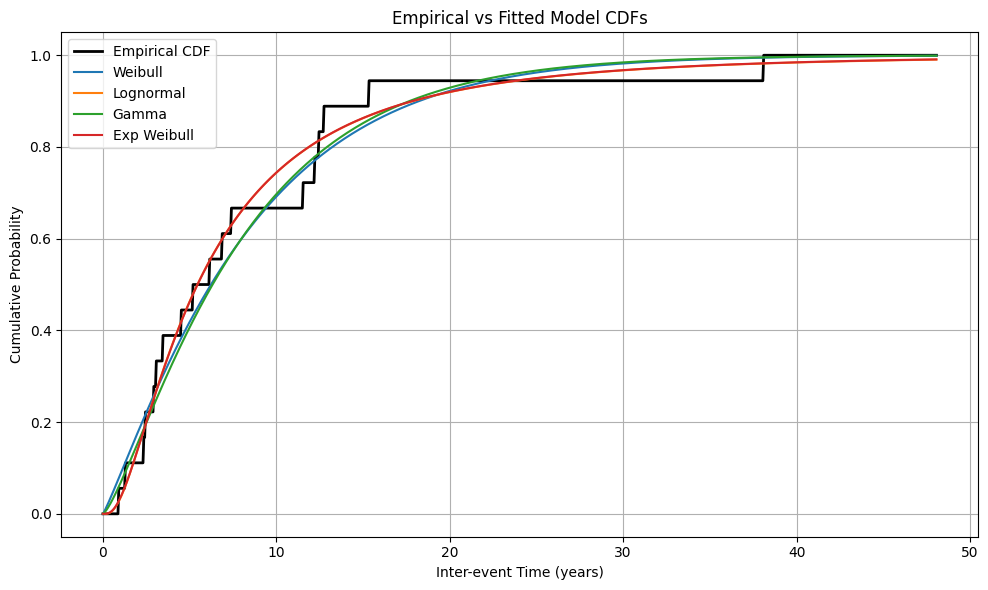


=== Parameter Summary ===
         Model  Param1  Param2  Param3  Log-Likelihood
0      Weibull  8.6448  1.1186     NaN        -55.7949
1    Lognormal  1.6948  0.9270     NaN        -54.6839
2        Gamma  1.3444  6.1397     NaN        -55.5469
3  Exp Weibull  0.4389  0.4202  12.042        -54.6987

=== AIC Comparison ===
         Model  Log-Likelihood  Parameters       AIC
1    Lognormal        -54.6839           2  113.3678
2        Gamma        -55.5469           2  115.0937
3  Exp Weibull        -54.6987           3  115.3974
0      Weibull        -55.7949           2  115.5898


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, expon, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load CSV ===
df = pd.read_csv('/content/ISC.csv')  # <-- Replace with actual filename
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])

print(df.head(13))

# === Sort and compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25

# === Remove 0 or negative intervals
interevent_times = interevent_times_raw[interevent_times_raw > 0].values
print(f"⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === Empirical CDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, interevent_times.max() + 10, 1000)

# === Weibull ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log(b / a * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, x0=[np.mean(interevent_times), 1.0],
                       args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc=loc_ln, scale=scale_ln))

# === Gamma ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, a=shape_g, loc=loc_g, scale=scale_g))

# === Custom Exponential-like ===
def custom_exp_pdf(t, p, q):
    return p * np.exp((p / q) * (1 - np.exp(q * t)) + q ** t)

def custom_exp_cdf(t, p, q, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = custom_exp_pdf(t_vals, p, q)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def custom_exp_nll(params, data):
    p, q = params
    if p <= 0 or q <= 0:
        return np.inf
    pdf_vals = custom_exp_pdf(data, p, q)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_custom = minimize(custom_exp_nll, x0=[0.1, 0.1], args=(interevent_times,),
                      bounds=[(1e-5, 5), (1e-5, 5)], method='L-BFGS-B')
p_custom, q_custom = res_custom.x
loglike_custom = -custom_exp_nll([p_custom, q_custom], interevent_times)

# === BPT ===
def bpt_pdf(t, mean, aperiod):
    sigma = aperiod * mean
    with np.errstate(divide='ignore', invalid='ignore'):
        pdf = (mean / (np.sqrt(2 * np.pi) * sigma * t**1.5)) * np.exp(-(t - mean)**2 / (2 * sigma**2))
    pdf[t <= 0] = 0
    return pdf

def bpt_cdf(t, mean, aperiod, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = bpt_pdf(t_vals, mean, aperiod)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def bpt_nll(params, data):
    mean, aperiod = params
    if mean <= 0 or aperiod <= 0:
        return np.inf
    pdf_vals = bpt_pdf(data, mean, aperiod)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_bpt = minimize(bpt_nll, x0=[np.mean(interevent_times), 0.3], args=(interevent_times,),
                   bounds=[(1e-5, None), (1e-5, 1.5)], method='L-BFGS-B')
mu_bpt, aperiod_bpt = res_bpt.x
loglike_bpt = -bpt_nll([mu_bpt, aperiod_bpt], interevent_times)

# === Exponentiated Weibull ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(- (t / a) ** b)
    factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_cdf(t, a, b, c):
    return (1 - np.exp(- (t / a)**b)) ** c

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, x0=[np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B',
                  bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)


# === CDF Plot ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
#plt.plot(x_vals, custom_exp_cdf(x_vals, p_custom, q_custom), label='Custom Exp-like')
#plt.plot(x_vals, bpt_cdf(x_vals, mu_bpt, aperiod_bpt), label='BPT')
plt.plot(x_vals, exp_weibull_cdf(x_vals, a_ew, b_ew, c_ew), label='Exp Weibull')

plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Fitted Model CDFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Summary Table ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'Log-Likelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'Log-Likelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'Log-Likelihood': loglike_gamma},
    #{'Model': 'Custom Exp-like', 'Param1': p_custom, 'Param2': q_custom, 'Param3': None, 'Log-Likelihood': loglike_custom},
    #{'Model': 'BPT', 'Param1': mu_bpt, 'Param2': aperiod_bpt, 'Param3': None, 'Log-Likelihood': loglike_bpt},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'Log-Likelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))


# === AIC Table ===
model_info = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    #("Custom Exp-like", loglike_custom, 2),
    #("BPT", loglike_bpt, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in model_info]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))

        date  latitude  longitude    mw
0 1967-12-10   17.4120    73.8850  6.54
1 2001-01-26   23.4190    70.2320  7.70
2 2013-09-24   26.9510    65.5009  7.70
3 2013-09-28   27.1825    65.5052  6.80
4 1990-06-17   27.3980    65.7190  6.10
⚠️ Removed 6 zero or negative inter-event times.


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



=== Parameter Summary ===
         Model  Param1  Param2  Param3  Log-Likelihood
0      Weibull  0.6092  0.8790     NaN        -52.4162
1    Lognormal -1.1702  1.4831     NaN        -61.0793
2        Gamma  0.8060  0.8034     NaN        -52.1427
3  Exp Weibull  1.0444  1.3314  0.5283        -51.7916


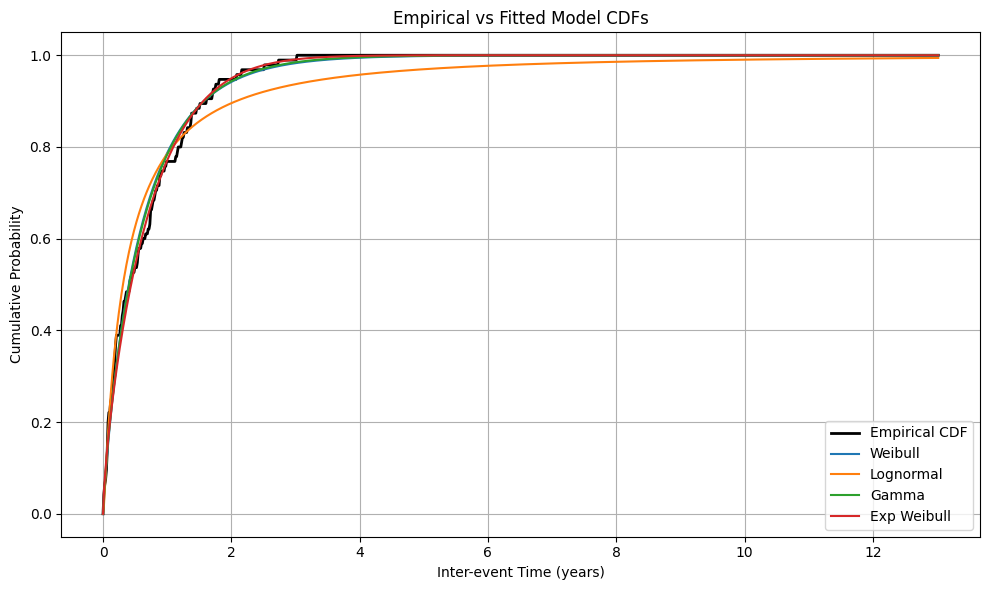


=== AIC Comparison ===
         Model  Log-Likelihood  Parameters       AIC
2        Gamma        -52.1427           2  108.2854
0      Weibull        -52.4162           2  108.8324
3  Exp Weibull        -51.7916           3  109.5833
1    Lognormal        -61.0793           2  126.1586


In [ ]:
##old
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, expon, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load CSV ===
df = pd.read_csv('/content/hindukush_2.csv')  # <-- Replace with actual filename
df = pd.read_csv('/content/hindukush_2.csv')
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])

print(df.head(5))


# === Sort and compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25

# === Remove 0 or negative intervals
interevent_times = interevent_times_raw[interevent_times_raw > 0].values
print(f"⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === Empirical CDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, interevent_times.max() + 10, 1000)

# === Weibull ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log(b / a * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, x0=[np.mean(interevent_times), 1.0],
                       args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc=loc_ln, scale=scale_ln))

# === Gamma ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, a=shape_g, loc=loc_g, scale=scale_g))

# === Custom Exponential-like ===
def custom_exp_pdf(t, p, q):
    return p * np.exp((p / q) * (1 - np.exp(q * t)) + q ** t)

def custom_exp_cdf(t, p, q, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = custom_exp_pdf(t_vals, p, q)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def custom_exp_nll(params, data):
    p, q = params
    if p <= 0 or q <= 0:
        return np.inf
    pdf_vals = custom_exp_pdf(data, p, q)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_custom = minimize(custom_exp_nll, x0=[0.1, 0.1], args=(interevent_times,),
                      bounds=[(1e-5, 5), (1e-5, 5)], method='L-BFGS-B')
p_custom, q_custom = res_custom.x
loglike_custom = -custom_exp_nll([p_custom, q_custom], interevent_times)

# === BPT ===
def bpt_pdf(t, mean, aperiod):
    sigma = aperiod * mean
    with np.errstate(divide='ignore', invalid='ignore'):
        pdf = (mean / (np.sqrt(2 * np.pi) * sigma * t**1.5)) * np.exp(-(t - mean)**2 / (2 * sigma**2))
    pdf[t <= 0] = 0
    return pdf

def bpt_cdf(t, mean, aperiod, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = bpt_pdf(t_vals, mean, aperiod)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def bpt_nll(params, data):
    mean, aperiod = params
    if mean <= 0 or aperiod <= 0:
        return np.inf
    pdf_vals = bpt_pdf(data, mean, aperiod)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_bpt = minimize(bpt_nll, x0=[np.mean(interevent_times), 0.3], args=(interevent_times,),
                   bounds=[(1e-5, None), (1e-5, 1.5)], method='L-BFGS-B')
mu_bpt, aperiod_bpt = res_bpt.x
loglike_bpt = -bpt_nll([mu_bpt, aperiod_bpt], interevent_times)

# === Exponentiated Weibull ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(- (t / a) ** b)
    factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_cdf(t, a, b, c):
    return (1 - np.exp(- (t / a)**b)) ** c

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, x0=[np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B',
                  bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)

# === Summary Table ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'Log-Likelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'Log-Likelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'Log-Likelihood': loglike_gamma},
    #{'Model': 'Custom Exp-like', 'Param1': p_custom, 'Param2': q_custom, 'Param3': None, 'Log-Likelihood': loglike_custom},
    #{'Model': 'BPT', 'Param1': mu_bpt, 'Param2': aperiod_bpt, 'Param3': None, 'Log-Likelihood': loglike_bpt},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'Log-Likelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))

# === CDF Plot ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
#plt.plot(x_vals, custom_exp_cdf(x_vals, p_custom, q_custom), label='Custom Exp-like')
#plt.plot(x_vals, bpt_cdf(x_vals, mu_bpt, aperiod_bpt), label='BPT')
plt.plot(x_vals, exp_weibull_cdf(x_vals, a_ew, b_ew, c_ew), label='Exp Weibull')

plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Fitted Model CDFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === AIC Table ===
model_info = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    #("Custom Exp-like", loglike_custom, 2),
    #("BPT", loglike_bpt, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in model_info]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))


⚠️ Removed 0 zero or negative inter-event times.


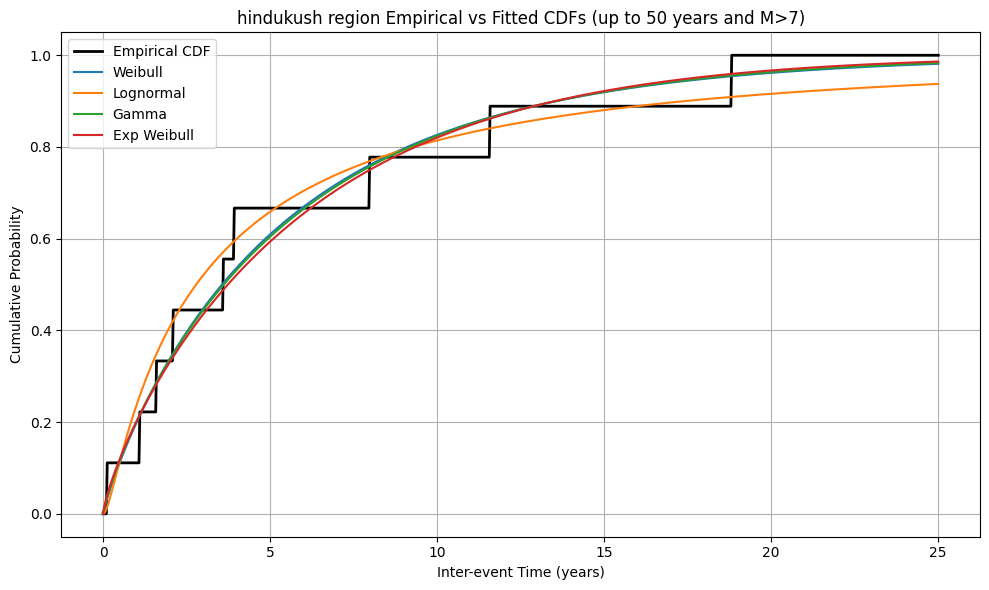


=== Parameter Summary ===
         Model  Param1  Param2  Param3  LogLikelihood
0      Weibull  5.3577  0.8976     NaN       -24.4767
1    Lognormal  1.0251  1.4295     NaN       -25.2126
2        Gamma  0.8377  6.7289     NaN       -24.4654
3  Exp Weibull  7.5162  1.1357  0.6854       -24.4565

=== AIC Comparison ===
         Model  Log-Likelihood  Parameters      AIC
2        Gamma        -24.4654           2  52.9307
0      Weibull        -24.4767           2  52.9534
1    Lognormal        -25.2126           2  54.4251
3  Exp Weibull        -24.4565           3  54.9130

✅ Total earthquakes with Mw > 7 used in analysis: 10


In [21]:
##best for cumulative till now
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load and Filter CSV ===
df = pd.read_csv('/content/hindukush_2.csv')  # Update with your actual path if needed
df.columns = df.columns.str.strip().str.lower()
df = df.rename(columns={'mw': 'magnitude'})
df['date'] = pd.to_datetime(df['date'])

# 🔹 Filter earthquakes with Mw > 6.5
df = df[df['magnitude'] > 7]
total_events = len(df)

# === Compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25
interevent_times = interevent_times_raw[interevent_times_raw > 0].values

print(f"\n⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === ECDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, 25, 1000)

# === Weibull Model ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log((b / a) * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, [np.mean(interevent_times), 1], args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal Model ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc_ln, scale_ln))

# === Gamma Model ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, shape_g, loc_g, scale_g))

# === Exponentiated Weibull Model ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(-(t / a) ** b)
    factor = c * (1 - np.exp(-(t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, [np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B', bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)

# === Plot CDFs ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
plt.plot(x_vals, (1 - np.exp(- (x_vals / a_ew) ** b_ew)) ** c_ew, label='Exp Weibull')
plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')
plt.title('hindukush region Empirical vs Fitted CDFs (up to 50 years and M>7)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Parameter Summary ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'LogLikelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'LogLikelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'LogLikelihood': loglike_gamma},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'LogLikelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))

# === AIC Table ===
models = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in models]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))

# === Total events printed ===
print(f"\n✅ Total earthquakes with Mw > 7 used in analysis: {total_events}")


⚠️ Removed 0 zero or negative inter-event times.

=== Parameter Summary ===
         Model   Param1   Param2  Param3  Log-Likelihood
0      Weibull  14.7354   2.8664     NaN        -30.1812
1    Lognormal   2.4862   0.4324     NaN        -30.6678
2        Gamma   5.9868   2.1868     NaN        -30.3810
3  Exp Weibull  20.4656  10.6986  0.1688        -30.0151


/tmp/ipython-input-9-915051398.py:105: RuntimeWarning: divide by zero encountered in power
  factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


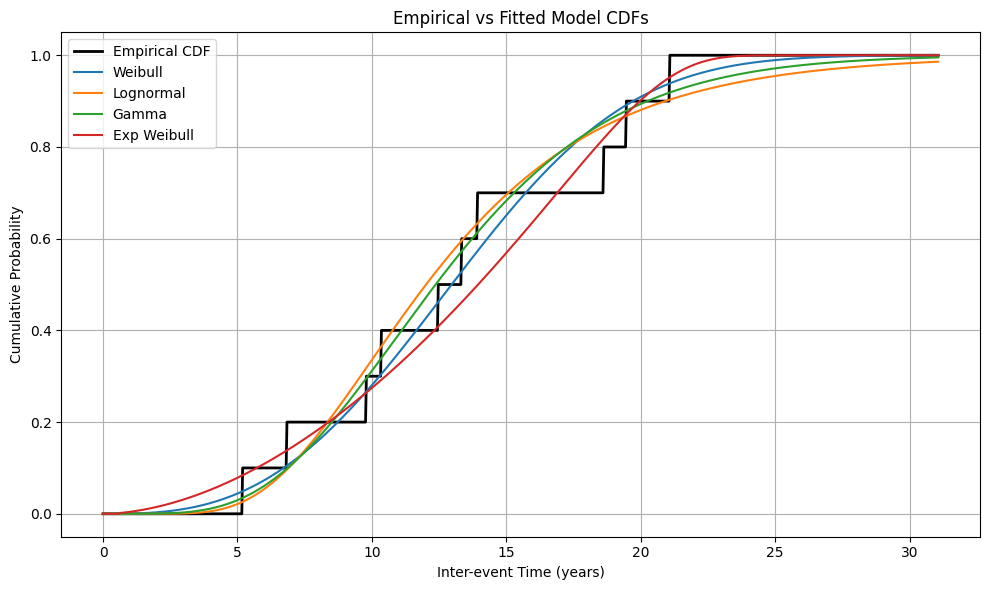


=== AIC Comparison ===
         Model  Log-Likelihood  Parameters      AIC
0      Weibull        -30.1812           2  64.3625
2        Gamma        -30.3810           2  64.7621
1    Lognormal        -30.6678           2  65.3356
3  Exp Weibull        -30.0151           3  66.0301


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, expon, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load CSV ===
df = pd.read_csv('/content/NE.csv')  # <-- Replace with actual filename
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])

#print(df.head(13))

# === Sort and compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25

# === Remove 0 or negative intervals
interevent_times = interevent_times_raw[interevent_times_raw > 0].values
print(f"⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === Empirical CDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, interevent_times.max() + 10, 1000)

# === Weibull ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log(b / a * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, x0=[np.mean(interevent_times), 1.0],
                       args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc=loc_ln, scale=scale_ln))

# === Gamma ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, a=shape_g, loc=loc_g, scale=scale_g))

# === Custom Exponential-like ===
def custom_exp_pdf(t, p, q):
    return p * np.exp((p / q) * (1 - np.exp(q * t)) + q ** t)

def custom_exp_cdf(t, p, q, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = custom_exp_pdf(t_vals, p, q)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def custom_exp_nll(params, data):
    p, q = params
    if p <= 0 or q <= 0:
        return np.inf
    pdf_vals = custom_exp_pdf(data, p, q)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_custom = minimize(custom_exp_nll, x0=[0.1, 0.1], args=(interevent_times,),
                      bounds=[(1e-5, 5), (1e-5, 5)], method='L-BFGS-B')
p_custom, q_custom = res_custom.x
loglike_custom = -custom_exp_nll([p_custom, q_custom], interevent_times)

# === BPT ===
def bpt_pdf(t, mean, aperiod):
    sigma = aperiod * mean
    with np.errstate(divide='ignore', invalid='ignore'):
        pdf = (mean / (np.sqrt(2 * np.pi) * sigma * t**1.5)) * np.exp(-(t - mean)**2 / (2 * sigma**2))
    pdf[t <= 0] = 0
    return pdf

def bpt_cdf(t, mean, aperiod, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = bpt_pdf(t_vals, mean, aperiod)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def bpt_nll(params, data):
    mean, aperiod = params
    if mean <= 0 or aperiod <= 0:
        return np.inf
    pdf_vals = bpt_pdf(data, mean, aperiod)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_bpt = minimize(bpt_nll, x0=[np.mean(interevent_times), 0.3], args=(interevent_times,),
                   bounds=[(1e-5, None), (1e-5, 1.5)], method='L-BFGS-B')
mu_bpt, aperiod_bpt = res_bpt.x
loglike_bpt = -bpt_nll([mu_bpt, aperiod_bpt], interevent_times)

# === Exponentiated Weibull ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(- (t / a) ** b)
    factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_cdf(t, a, b, c):
    return (1 - np.exp(- (t / a)**b)) ** c

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, x0=[np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B',
                  bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)

# === Summary Table ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'Log-Likelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'Log-Likelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'Log-Likelihood': loglike_gamma},
    #{'Model': 'Custom Exp-like', 'Param1': p_custom, 'Param2': q_custom, 'Param3': None, 'Log-Likelihood': loglike_custom},
    #{'Model': 'BPT', 'Param1': mu_bpt, 'Param2': aperiod_bpt, 'Param3': None, 'Log-Likelihood': loglike_bpt},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'Log-Likelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))

# === CDF Plot ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
#plt.plot(x_vals, custom_exp_cdf(x_vals, p_custom, q_custom), label='Custom Exp-like')
#plt.plot(x_vals, bpt_cdf(x_vals, mu_bpt, aperiod_bpt), label='BPT')
plt.plot(x_vals, exp_weibull_cdf(x_vals, a_ew, b_ew, c_ew), label='Exp Weibull')

plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Fitted Model CDFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === AIC Table ===
model_info = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    #("Custom Exp-like", loglike_custom, 2),
    #("BPT", loglike_bpt, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in model_info]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))

         date  latitude  longitude        mw
0  2009-08-10   14.0990    92.9020  7.500000
1  1964-07-28   14.1170    96.0740  6.400000
2  1991-04-01   15.7460    95.7380  6.000000
3  1995-05-16   17.8990    96.4570  6.080133
4  2018-01-11   18.3719    96.0717  6.000000
5  1996-11-11   19.3300    95.0130  6.000000
6  2014-05-05   19.6557    99.6696  6.100000
7  2003-09-21   19.9170    95.6720  6.600000
8  1994-05-29   20.5560    94.1600  6.500000
9  2011-03-24   20.6870    99.8220  6.900000
10 2016-08-24   20.9228    94.5690  6.800000
11 1975-07-08   21.4850    94.7000  6.597000
12 1964-02-27   21.5460    94.3470  6.050000
⚠️ Removed 4 zero or negative inter-event times.


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


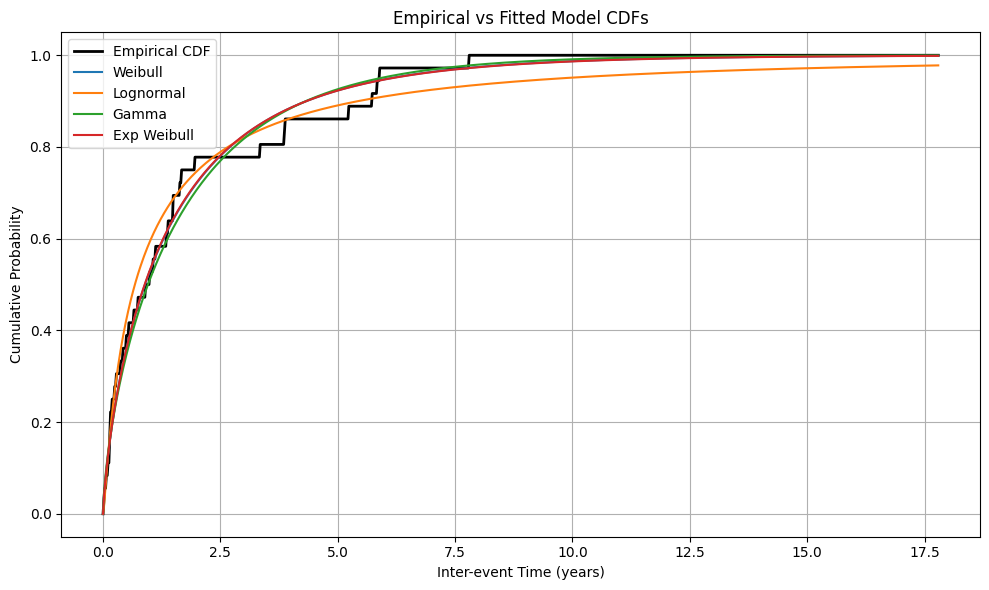


=== Parameter Summary ===
         Model  Param1  Param2  Param3  Log-Likelihood
0      Weibull  1.4455  0.7601     NaN        -52.6062
1    Lognormal -0.3878  1.6234     NaN        -54.5629
2        Gamma  0.6633  2.5622     NaN        -52.7176
3  Exp Weibull  1.3686  0.7400   1.047        -52.6052

=== AIC Comparison ===
         Model  Log-Likelihood  Parameters       AIC
0      Weibull        -52.6062           2  109.2125
2        Gamma        -52.7176           2  109.4353
3  Exp Weibull        -52.6052           3  111.2104
1    Lognormal        -54.5629           2  113.1258


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import lognorm, expon, gamma
from scipy.integrate import cumulative_trapezoid
from statsmodels.distributions.empirical_distribution import ECDF

# === Load CSV ===
df = pd.read_csv('/content/burma_2.csv')  # <-- Replace with actual filename
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])

print(df.head(13))

# === Sort and compute inter-event times in years ===
df = df.sort_values('date')
interevent_times_raw = df['date'].diff().dropna().dt.days / 365.25

# === Remove 0 or negative intervals
interevent_times = interevent_times_raw[interevent_times_raw > 0].values
print(f"⚠️ Removed {len(interevent_times_raw) - len(interevent_times)} zero or negative inter-event times.")

# === Empirical CDF ===
ecdf = ECDF(interevent_times)
x_vals = np.linspace(0, interevent_times.max() + 10, 1000)

# === Weibull ===
def weibull_nll(params, data):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(np.log(b / a * (data / a)**(b - 1) * np.exp(-(data / a)**b)))

res_weibull = minimize(weibull_nll, x0=[np.mean(interevent_times), 1.0],
                       args=(interevent_times,), method='Nelder-Mead')
alpha_weibull, beta_weibull = res_weibull.x
loglike_weibull = -weibull_nll([alpha_weibull, beta_weibull], interevent_times)

# === Lognormal ===
shape_ln, loc_ln, scale_ln = lognorm.fit(interevent_times, floc=0)
mu_ln = np.log(scale_ln)
sigma_ln = shape_ln
loglike_lognorm = np.sum(lognorm.logpdf(interevent_times, shape_ln, loc=loc_ln, scale=scale_ln))

# === Gamma ===
shape_g, loc_g, scale_g = gamma.fit(interevent_times, floc=0)
loglike_gamma = np.sum(gamma.logpdf(interevent_times, a=shape_g, loc=loc_g, scale=scale_g))

# === Custom Exponential-like ===
def custom_exp_pdf(t, p, q):
    return p * np.exp((p / q) * (1 - np.exp(q * t)) + q ** t)

def custom_exp_cdf(t, p, q, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = custom_exp_pdf(t_vals, p, q)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def custom_exp_nll(params, data):
    p, q = params
    if p <= 0 or q <= 0:
        return np.inf
    pdf_vals = custom_exp_pdf(data, p, q)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_custom = minimize(custom_exp_nll, x0=[0.1, 0.1], args=(interevent_times,),
                      bounds=[(1e-5, 5), (1e-5, 5)], method='L-BFGS-B')
p_custom, q_custom = res_custom.x
loglike_custom = -custom_exp_nll([p_custom, q_custom], interevent_times)

# === BPT ===
def bpt_pdf(t, mean, aperiod):
    sigma = aperiod * mean
    with np.errstate(divide='ignore', invalid='ignore'):
        pdf = (mean / (np.sqrt(2 * np.pi) * sigma * t**1.5)) * np.exp(-(t - mean)**2 / (2 * sigma**2))
    pdf[t <= 0] = 0
    return pdf

def bpt_cdf(t, mean, aperiod, steps=1000):
    t_vals = np.linspace(0, t.max(), steps)
    pdf_vals = bpt_pdf(t_vals, mean, aperiod)
    cdf_vals = cumulative_trapezoid(pdf_vals, t_vals, initial=0)
    return np.interp(t, t_vals, cdf_vals / cdf_vals[-1])

def bpt_nll(params, data):
    mean, aperiod = params
    if mean <= 0 or aperiod <= 0:
        return np.inf
    pdf_vals = bpt_pdf(data, mean, aperiod)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_bpt = minimize(bpt_nll, x0=[np.mean(interevent_times), 0.3], args=(interevent_times,),
                   bounds=[(1e-5, None), (1e-5, 1.5)], method='L-BFGS-B')
mu_bpt, aperiod_bpt = res_bpt.x
loglike_bpt = -bpt_nll([mu_bpt, aperiod_bpt], interevent_times)

# === Exponentiated Weibull ===
def exp_weibull_pdf(t, a, b, c):
    base = (b / a) * (t / a) ** (b - 1) * np.exp(- (t / a) ** b)
    factor = c * (1 - np.exp(- (t / a) ** b)) ** (c - 1)
    pdf = base * factor
    pdf[(t <= 0) | np.isnan(pdf) | np.isinf(pdf)] = 0
    return pdf

def exp_weibull_cdf(t, a, b, c):
    return (1 - np.exp(- (t / a)**b)) ** c

def exp_weibull_nll(params, data):
    a, b, c = params
    if any(p <= 0 for p in params):
        return np.inf
    pdf_vals = exp_weibull_pdf(data, a, b, c)
    if np.any(pdf_vals <= 0):
        return np.inf
    return -np.sum(np.log(pdf_vals))

res_ew = minimize(exp_weibull_nll, x0=[np.mean(interevent_times), 1, 1],
                  args=(interevent_times,), method='L-BFGS-B',
                  bounds=[(1e-5, None)] * 3)
a_ew, b_ew, c_ew = res_ew.x
loglike_ew = -exp_weibull_nll([a_ew, b_ew, c_ew], interevent_times)



# === CDF Plot ===
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf(x_vals), label='Empirical CDF', color='black', lw=2)
plt.plot(x_vals, 1 - np.exp(-(x_vals / alpha_weibull)**beta_weibull), label='Weibull')
plt.plot(x_vals, lognorm.cdf(x_vals, shape_ln, loc_ln, scale_ln), label='Lognormal')
plt.plot(x_vals, gamma.cdf(x_vals, shape_g, loc_g, scale_g), label='Gamma')
#plt.plot(x_vals, custom_exp_cdf(x_vals, p_custom, q_custom), label='Custom Exp-like')
#plt.plot(x_vals, bpt_cdf(x_vals, mu_bpt, aperiod_bpt), label='BPT')
plt.plot(x_vals, exp_weibull_cdf(x_vals, a_ew, b_ew, c_ew), label='Exp Weibull')

plt.xlabel('Inter-event Time (years)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Fitted Model CDFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Summary Table ===
summary = pd.DataFrame([
    {'Model': 'Weibull', 'Param1': alpha_weibull, 'Param2': beta_weibull, 'Param3': None, 'Log-Likelihood': loglike_weibull},
    {'Model': 'Lognormal', 'Param1': mu_ln, 'Param2': sigma_ln, 'Param3': None, 'Log-Likelihood': loglike_lognorm},
    {'Model': 'Gamma', 'Param1': shape_g, 'Param2': scale_g, 'Param3': None, 'Log-Likelihood': loglike_gamma},
    #{'Model': 'Custom Exp-like', 'Param1': p_custom, 'Param2': q_custom, 'Param3': None, 'Log-Likelihood': loglike_custom},
    #{'Model': 'BPT', 'Param1': mu_bpt, 'Param2': aperiod_bpt, 'Param3': None, 'Log-Likelihood': loglike_bpt},
    {'Model': 'Exp Weibull', 'Param1': a_ew, 'Param2': b_ew, 'Param3': c_ew, 'Log-Likelihood': loglike_ew}
])
print("\n=== Parameter Summary ===")
print(summary.round(4))
# === AIC Table ===
model_info = [
    ("Weibull", loglike_weibull, 2),
    ("Lognormal", loglike_lognorm, 2),
    ("Gamma", loglike_gamma, 2),
    #("Custom Exp-like", loglike_custom, 2),
    #("BPT", loglike_bpt, 2),
    ("Exp Weibull", loglike_ew, 3)
]
aic_df = pd.DataFrame([{
    "Model": name,
    "Log-Likelihood": logL,
    "Parameters": k,
    "AIC": 2 * k - 2 * logL
} for name, logL, k in model_info]).sort_values("AIC")

print("\n=== AIC Comparison ===")
print(aic_df.round(4))


#in this code take 2 parameters of exponential weibull as 0:460602 and13:447897